![](https://imgur.com/QnT31vZ.png)

---

# Sobre o desafio

Na semana 02, vamos focar na construção e otimização de modelos de machine learning (ML) para lidar com a Taxa de Churn. Agora que terminamos a análise inicial dos dados na semana 01, é hora de usar algoritmos de ML para transformar nossos insights em ações eficazes.

## Carregando os dados da Semana 01

In [2]:
import pandas as pd

dados = pd.read_csv('Dados/dados_tratados.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   Seniorcitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   Phoneservice      7043 non-null   object 
 7   Multiplelines     7043 non-null   object 
 8   Internetservice   7043 non-null   object 
 9   Onlinesecurity    7043 non-null   object 
 10  Onlinebackup      7043 non-null   object 
 11  Deviceprotection  7043 non-null   object 
 12  Techsupport       7043 non-null   object 
 13  Streamingtv       7043 non-null   object 
 14  Streamingmovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperlessbilling  7043 non-null   object 


<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Lidando com o desbalanceamento de dados da target</h1>
</div>

Durante a primeira semana do nosso projeto, uma observação veio à tona: nossos dados da target apresentam um desbalanceamento, conforme evidenciado abaixo:

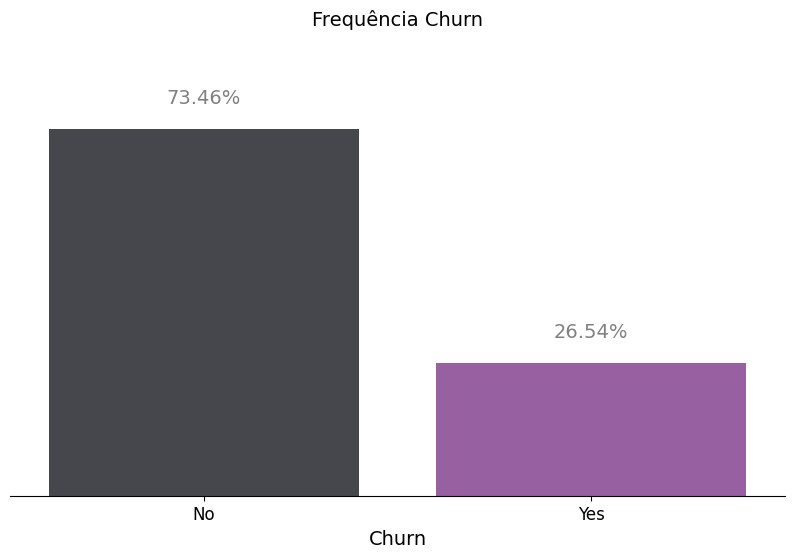

In [2]:
import justplotit as jpi
jpi.frequencia_churn(dados)

O que esse balanceamento nos diz se quisermos prever quais clientes deixaram a empresa Novexus? Quando formos criar nosso modelo de Machine Learning, treinar e avaliar, vamos eventualmente perceber que o modelo terá um bom desempenho para prever corretamente que os clientes que saíram da empresa realmente saíram, mas ele vai ter um péssimo desempenho para identificar corretamente quais clientes saíram da empresa (recall baixo e, eventualmente, o f1-score será baixo também). Assim o modelo está estaria fazendo bom trabalho em identificar clientes que não irão sair da empresa, mas está falhando em identificar clientes que irão sair da empresa.

Para melhorar o desempenho do modelo, podemos pensar em três alternativas: 

1. Deixamos esses dados balanceados adicionando mais features relevantes ao conjunto de dados de treinamento;

2. Implementar uma técnica de oversampling (SMOTE) ou

3. uma técnica de Undersampling (Tomek Links).


## Abordagem 1: Ignorar o desbalanceamento

> A primeira abordagem consiste em ignorar completamente o desbalanceamento e construir nosso modelo sem fazer ajustes específicos para corrigir. Se desenvolvermos um modelo sem considerar essa desproporcionalidade nos dados, o modelo será vítima do Paradoxo da Acurácia, em que os parâmetros do algoritmo não diferenciarão a classe minoritária das demais categorias, acreditando que estão agregando resultado devido à aparente alta acurácia.

## Abordagem 2: Oversamplig

> A segunda abordagem é utilizar a técnica [SMOTE](https://arxiv.org/pdf/1106.1813.pdf) (Synthetic Minority Over-sampling Technique). Essa técnica envolve a criação de informações sintéticas com base nas observações já existentes na classe minoritária. Esses dados "sintéticos" são gerados de forma a serem semelhantes aos dados reais, embora não sejam idênticos. Essa abordagem visa equilibrar a representação das classes, tornando o modelo mais capaz de identificar corretamente os casos da classe minoritária. Essa técnica no entanto pde introduzir viés nos dados ao gerar amostras sintéticas que estão próximas de exemplos existentes da classe minoritária. Isso pode levar a um melhor desempenho do modelo na classe minoritária, mas pode prejudicar o desempenho do modelo na classe majoritária.

![](https://imgur.com/KCTDPZG.png)

## Abordagem 3: Undersampling

> A terceira abordagem é usar Tomek Links é uma técnica de subamostragem que foi desenvolvida em 1976 por [Ivan Tomek](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4309452). É uma modificação do Condensed Nearest Neighbors (CNN). Ele pode ser utilizado para identificar amostras desejadas da classe majoritária que apresentem a menor distância euclidiana com os dados da classe minoritária e, em seguida, removê-las. 

![](https://imgur.com/6FTLQ0M.png)

## Quando iremos aplicar essas técnicas?

A regra fundamental é: nunca mexa com seu conjunto de teste. Sempre divida-o em conjuntos de teste e treinamento ANTES de tentar aplicar técnicas de oversampling/undersampling!

Realizar oversampling antes da divisão dos dados pode resultar na presença das mesmas observações em ambos os conjuntos de teste e treinamento. Isso possibilita que o modelo simplesmente memorize pontos de dados específicos, o que leva ao overfitting e à má generalização para os dados de teste. O vazamento de dados pode causar a criação de modelos preditivos excessivamente otimistas, senão completamente inválidos.

Além disso, não devemos fazer isso antes da validação cruzada. Isso ocorre porque ao fazer isso antecipadamente, você estará influenciando diretamente o conjunto de validação antes de realizar a validação cruzada, o que pode resultar em um problema de "data leakage".

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Feature Engineering e Encoding + Pipeline</h1>
</div>

Iremos adicionar uma nova variável intitulada `TotalServices`, que é uma contagem do número total de serviços que um cliente está inscrito (os serviços são: `Multiplelines`, `Onlinesecurity`, `Onlinebackup`, `Deviceprotection`, `Techsupport`, `Streamingtv`, `Streamingmovies`). Além disso, iremos substituir todas as células que possuem `No internet service` ou `No phone service` por `No` visto que já existe uma coluna que informa sobre isso.

In [3]:
import justdoit as jdi

# Precisamos separar nossos dados!
X = dados.drop('Churn', axis = 1)                # Features
y = dados['Churn'].replace({'Yes': 1, 'No': 0})  # Target

# Substituindo algumas coisas desnecessárias...
X = X.where((X != 'No internet service') & (X != 'No phone service'), 'No')

# Adicionando uma nova feature!
jdi.TotalServiceTransformer(X)

O código abaixo está preparando os dados para o modelo ML usando pipelines e transformadores. Cada linha do código é explicada abaixo:

- `cols_num` e `cols_cat`: Define as features numéricas e categóricas (respectivamente) do conjunto de dados que precisam ser pré-processadas.

Logo em seguida temos a criação do pipeline de pré-processamento para os dados categóricos e numéricos:

- A primeira etapa é o codificador `CatBoost`. É um codificador supervisionado de variáveis categóricas baseado no algoritmo CatBoost, na qual codifica essas colunas de acordo com o valor da target.

- A segunda etapa é padronizar os dados numéricos com `StandardScaler`. Isso significa que aqui vamos transformar os dados de modo que a média de cada coluna seja 0 e o desvio padrão de cada coluna seja 1.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.compose import ColumnTransformer

cols_num = list(set(X.select_dtypes('number')))
cols_cat = list(set(X.select_dtypes('object')))

pipe_cat = Pipeline([('encoder', CatBoostEncoder())])
pipe_num = Pipeline([('std_scaler', StandardScaler())])

preprocessor = ColumnTransformer([('numeric', pipe_num, cols_num),
                                  ('categoric', pipe_cat, cols_cat)])
preprocessor

#pipeline_completo =Pipeline([('Preprocessor',preprocessor),('model', None)])

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['Seniorcitizen', 'Charges_total', 'Tenure',
                                  'Charges_monthly', 'TotalServices']),
                                ('categoric',
                                 Pipeline(steps=[('encoder',
                                                  CatBoostEncoder())]),
                                 ['Deviceprotection', 'Onlinesecurity',
                                  'Multiplelines', 'Phoneservice', 'Gender',
                                  'Techsupport', 'Streamingmovies', 'Contract',
                                  'Partner', 'Paperlessbilling', 'Dependents',
                                  'Paymentmethod', 'Internetservice',
                                  'Streamingtv', 'Onlinebackup'])])

A partir deste ponto, nosso trabalho se ramificará nas três abordagens distintas que falamos anteriormente. Ao final, identificaremos qual delas é a mais eficaz, juntamente com a escolha do modelo de classificação adequado. Também discutiremos as medidas que a empresa Novexus pode adotar para reduzir a taxa de Churn.

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Construção do modelo</h1>
</div>

## Conjunto de treino e teste

In [5]:
from sklearn.model_selection import train_test_split

n = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = n)

##  Usando K-fold Cross-Validation

Uma maneira eficaz de avaliar o desempenho de um modelo de machine learning é através da validação cruzada, especificamente usando a técnica chamada de **K-fold Cross-Validation**. Em vez de simplesmente dividir o conjunto de treinamento em um grupo de treinamento e outro de validação, essa abordagem envolve dividir o conjunto de treinamento em **K** subconjuntos distintos chamados "folds". Em seu exemplo, usamos **K = 3**, o que significa que o conjunto de treinamento será dividido em 3 folds.

A ideia principal por trás do K-fold Cross-Validation é treinar e avaliar o modelo K vezes, onde em cada iteração um fold diferente é escolhido para ser o conjunto de validação, enquanto os outros **K - 1** folds são usados para treinamento. Isso nos permite obter várias estimativas do desempenho do modelo, reduzindo o impacto da aleatoriedade na divisão dos dados em apenas dois grupos (treinamento e validação).

Aqui entra em cena a observação sobre **`RepeatedStratifiedKFold`**. A estratégia de divisão dos dados em folds é importante para garantir que as classes estejam balanceadas em cada fold, especialmente quando lidamos com conjuntos de dados desequilibrados, onde uma classe tem muitos mais exemplos do que a outra. O `RepeatedStratifiedKFold` é uma variação do K-fold que mantém essa estratégia de divisão estratificada e também permite repetir o processo várias vezes para aumentar a robustez da avaliação do modelo. Em outras palavras, ele ajuda a garantir que a avaliação do modelo seja consistente e não dependa da aleatoriedade na escolha dos folds.

**Observação:** Oversampling e Undersampling foram usados apenas no conjunto de treinamento durante o Cross Validation!!!

In [6]:
df_over = jdi.cross_validation_models_set('Oversampling', preprocessor, X_train, y_train)
df_over.sort_values('F1-Score', ascending = False)

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.840,0.738,0.504,0.810,0.621
5,Support Vector Machine,0.832,0.741,0.508,0.812,0.621
4,Gradient Boosting,0.840,0.779,0.580,0.669,0.619
3,Floresta Randômica,0.833,0.791,0.615,0.576,0.595
1,K-Vizinhos Mais Próximos (KNN),0.772,0.704,0.465,0.745,0.572
2,Árvore de Decisão,0.666,0.720,0.469,0.511,0.479


In [7]:
df_under = jdi.cross_validation_models_set('Undersampling', preprocessor, X_train, y_train)
df_under.sort_values('F1-Score', ascending = False)

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
4,Gradient Boosting,0.845,0.800,0.626,0.611,0.618
0,Regressão Logística,0.840,0.796,0.615,0.617,0.616
3,Floresta Randômica,0.838,0.796,0.621,0.596,0.607
5,Support Vector Machine,0.813,0.793,0.634,0.525,0.574
1,K-Vizinhos Mais Próximos (KNN),0.786,0.762,0.547,0.601,0.572
2,Árvore de Decisão,0.672,0.721,0.481,0.567,0.519


In [8]:
df_def = jdi.cross_validation_models_set('Default', preprocessor, X_train, y_train)
df_def.sort_values('F1-Score', ascending = False)

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.840,0.801,0.656,0.528,0.584
4,Gradient Boosting,0.845,0.802,0.661,0.523,0.583
1,K-Vizinhos Mais Próximos (KNN),0.780,0.767,0.567,0.524,0.545
3,Floresta Randômica,0.833,0.794,0.660,0.465,0.541
5,Support Vector Machine,0.797,0.793,0.668,0.436,0.527
2,Árvore de Decisão,0.662,0.729,0.491,0.521,0.504


### Análise preliminar

Após o treinamento de 6 modelos, percebemos que, o melhor F1-Score foi:
- Para abordagem Oversamplig: o modelo Support Vector Machine
- Para abordagem Undersampling: o modelo Gradient Boosting
- Para abordagem Default: o modelo Regressão Logística.

Escolheremos mais dois modelos com melhor desempelho nessa métrica para cada abordagem e faremos um hyperparameter tuning usando Grid Search.

> Support Vector Machine, Regressão Logística, Gradient Boosting e Floresta Randômica.

## Hyperparameter tuning usando Grid Search

Vamos configurar a grade de parâmetros para cada modelo:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

svm_params = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear']
}

gradient_boosting_params = {
    'model__learning_rate': [0.1, 0.01],
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4, 5]
}

logistic_regression_params = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.1, 1, 10],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [1000]
}

random_forest_params = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [5, 10, 15]
}

modelos = {
    'Gradient Boosting': (GradientBoostingClassifier(random_state = n), gradient_boosting_params),
    'Logistic Regression': (LogisticRegression(random_state = n), logistic_regression_params),
    'Support Vector Machine (Linear Kernel)': (SVC(random_state = n), svm_params),
    'Floresta Randômica': (RandomForestClassifier(random_state = n), random_forest_params)
}

### Oversampling

In [12]:
from imblearn.over_sampling import SMOTE
gs_over = jdi.hyperparameter_optimization(SMOTE(), preprocessor, X_train, y_train, modelos)

Best parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 100}
Best parameters for Logistic Regression: {'model__C': 0.1, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best parameters for Support Vector Machine (Linear Kernel): {'model__C': 0.1, 'model__kernel': 'linear'}
Best parameters for Floresta Randômica: {'model__max_depth': 10, 'model__n_estimators': 150}


In [16]:
gs_over.sort_values('F1_score', ascending = False)

,model,F1_score,Accuracy
3,Floresta Randômica,0.730255,0.772985
0,Gradient Boosting,0.721536,0.767661
1,Logistic Regression,0.716305,0.745651
2,Support Vector Machine (Linear Kernel),0.691824,0.715122


### Undersampling

In [13]:
from imblearn.under_sampling import TomekLinks
gs_under = jdi.hyperparameter_optimization(TomekLinks(), preprocessor, X_train, y_train, modelos)

Best parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 100}
Best parameters for Logistic Regression: {'model__C': 10, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best parameters for Support Vector Machine (Linear Kernel): {'model__C': 10, 'model__kernel': 'linear'}
Best parameters for Floresta Randômica: {'model__max_depth': 5, 'model__n_estimators': 150}


In [17]:
gs_under.sort_values('F1_score', ascending = False)

,model,F1_score,Accuracy
1,Logistic Regression,0.738448,0.796060
3,Floresta Randômica,0.736150,0.798012
0,Gradient Boosting,0.734937,0.784878
2,Support Vector Machine (Linear Kernel),0.730297,0.791090


### Default

In [18]:
gs_def = jdi.hyperparameter_optimization(None, preprocessor, X_train, y_train, modelos)

Best parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best parameters for Logistic Regression: {'model__C': 10, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best parameters for Support Vector Machine (Linear Kernel): {'model__C': 10, 'model__kernel': 'linear'}
Best parameters for Floresta Randômica: {'model__max_depth': 10, 'model__n_estimators': 50}


In [19]:
gs_def.sort_values('F1_score', ascending = False)

,model,F1_score,Accuracy
0,Gradient Boosting,0.731286,0.788605
1,Logistic Regression,0.725899,0.799077
3,Floresta Randômica,0.725033,0.794995
2,Support Vector Machine (Linear Kernel),0.721790,0.796060


Observe o seguinte:

- Na **estratégia de Oversampling**, o melhor modelo, a Floresta Randômica, conseguiu atingir um F1-Score de 73,03%.
- Na **estratégia de Oversampling**, o melhor modelo, a Regressão Logística, conseguiu atingir um F1-Score de 73,84%.
- Na **estratégia Padrão**, o melhor modelo, o Gradient Boosting, conseguiu atingir um F1-Score de 73,12%.

Apesar dos três modelos terem pontuações muito próximas, a estratégia de Oversampling superou as outras duas abordagens. Vamos, portanto, utilizar esses três melhores modelos para avaliar no conjunto de teste e, em seguida, determinar definitivamente qual é o melhor modelo para prosseguirmos com o lançamento.

## Floresta Randômica, Regressão Logística e Gradient Boosting como melhores modelos

In [8]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as PipelineIMB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Oversampling {'model__max_depth': 10, 'model__n_estimators': 150}
random_forest = RandomForestClassifier(max_depth = 10, n_estimators = 150, random_state = n)
pipe_over = PipelineIMB([('preprocessor', preprocessor), ('resampler', SMOTE()), ('model', random_forest)])
pipe_over.fit(X_train, y_train)

# Undersampling {'model__C': 10, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
logistic_regression = LogisticRegression(C = 10, max_iter = 1000, penalty = 'l1', solver = 'liblinear', random_state = n)
pipe_under = PipelineIMB([('preprocessor', preprocessor), ('resampler', TomekLinks()), ('model', logistic_regression)])
pipe_under.fit(X_train, y_train)

# Default {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
gradient_boosting = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = n)
pipe_def = PipelineIMB([('preprocessor', preprocessor), ('model', gradient_boosting)])
pipe_def.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Seniorcitizen',
                                                   'Charges_total', 'Tenure',
                                                   'Charges_monthly',
                                                   'TotalServices']),
                                                 ('categoric',
                                                  Pipeline(steps=[('encoder',
                                                                   CatBoostEncoder())]),
                                                  ['Deviceprotection',
                                                   'Onlinesecurity',
                                                   'Multiplelines',
                                                   'Phoneservice', 'Gender',
                                                   'Techsupport',
                                                   'Streamingmovies',
                                                   'Contract', 'Partner',
                                                   'Paperlessbilling',
                                                   'Dependents',
                                                   'Paymentmethod',
                                                   'Internetservice',
                                                   'Streamingtv',
                                                   'Onlinebackup'])])),
                ('model', GradientBoostingClassifier(random_state=42))])

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Avaliação dos modelos</h1>
</div>

## Previsões dos Modelos

In [9]:
rf_predictions = pipe_over.predict(X_test)
lr_predictions = pipe_under.predict(X_test)
gb_predictions = pipe_def.predict(X_test)

## Comparação dos valores reais com os valores previstos

In [10]:
from sklearn.metrics import classification_report

rf_report = classification_report(y_test, rf_predictions)
print("Relatório de Classificação para Random Florest (Oversampling):")
print(rf_report)

Relatório de Classificação para Random Florest (Oversampling):
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1035
           1       0.59      0.69      0.64       374

    accuracy                           0.79      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.79      0.79      1409



1. **Precisão (Precision)**: A precisão é a proporção de verdadeiros positivos (churn previstos corretamente) em relação a todos os exemplos previstos como positivos (churn). No caso dos clientes propensos ao churn (classe 1), a precisão é de 0,59. Isso significa que, dos clientes previstos como propensos ao churn, apenas 57% deles realmente abandonaram o serviço.

2. **Revocação (Recall)**: A revocação é a proporção de verdadeiros positivos em relação a todos os exemplos reais de churn (classe 1). A revocação para a classe 1 é de 0,69. Isso significa que o modelo conseguiu capturar 69% dos clientes que realmente abandonaram o serviço.

3. **F1-Score**: O F1-Score é a média harmônica entre precisão e revocação. É uma métrica que equilibra a precisão e a revocação. O F1-Score para a classe 1 é de 0,64.

4. **Acurácia (Accuracy)**: A acurácia mede a proporção de previsões corretas em relação a todas as previsões. A acurácia geral do modelo é de 0,79, o que significa que 79% das previsões do modelo estão corretas.

No geral, o modelo parece ter um desempenho razoável, especialmente na previsão dos clientes propensos ao churn (classe 1).

In [11]:
lr_report = classification_report(y_test, lr_predictions)
print("\nRelatório de Classificação para Logistic Regression (Undersampling):")
print(lr_report)


Relatório de Classificação para Logistic Regression (Undersampling):
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1035
           1       0.60      0.61      0.61       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



1. **Precisão (Precision)**: A precisão para a classe 1 é de 0,61. Isso significa que, dos clientes previstos como propensos ao churn, 61% deles realmente abandonaram o serviço.

2. **Revocação (Recall)**: A revocação para a classe 1 é de 0,61. Isso indica que o modelo conseguiu capturar 61% dos clientes que realmente abandonaram o serviço.

3. **F1-Score**: O F1-Score para a classe 1 é de 0,61. É uma métrica que equilibra a precisão e a revocação.

4. **Acurácia (Accuracy)**: A acurácia geral do modelo é de 0,79, o que significa que 79% das previsões do modelo estão corretas.

Comparando este modelo de Regressão Logística com o modelo anterior de Random Forest (com oversampling), ambos têm uma acurácia semelhante. No entanto, a Regressão Logística tem uma precisão e revocação ligeiramente melhores para a classe 1, enquanto o Random Forest tinha uma precisão ligeiramente melhor, mas uma revocação um pouco pior para a mesma classe. O F1-Score é semelhante em ambos os modelos.

In [12]:
gb_report = classification_report(y_test, gb_predictions)
print("\nRelatório de Classificação para Gradient Boosting (Default sampling):")
print(gb_report)


Relatório de Classificação para Gradient Boosting (Default sampling):
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



1. **Precisão (Precision)**: A precisão para a classe 1 é de 0,65. Isso significa que, dos clientes previstos como propensos ao churn, 65% deles realmente abandonaram o serviço.

2. **Revocação (Recall)**: A revocação para a classe 1 é de 0,54. Isso indica que o modelo conseguiu capturar apenas 54% dos clientes que realmente abandonaram o serviço.

3. **F1-Score**: O F1-Score para a classe 1 é de 0,59. Como nas análises anteriores, o F1-Score é uma métrica que equilibra precisão e revocação.

4. **Acurácia (Accuracy)**: A acurácia geral do modelo é de 0,80, o que significa que 80% das previsões do modelo estão corretas.

Comparando este modelo de Gradient Boosting com os modelos anteriores (Regressão Logística e Random Forest), observamos que o Gradient Boosting tem uma acurácia ligeiramente maior. No entanto, a precisão para a classe 1 é menor do que a da Regressão Logística e a revocação é menor do que a do Random Forest. O F1-Score também é um pouco mais baixo em comparação com os outros dois modelos.

### "Melhor modelo" de acordo com a problemática

Embora a precisão do modelo seja uma métrica comumente usada para avaliar o desempenho de modelos de ML, acreditamos que não deve ser o único fator decisivo para selecionar o modelo mais adequado para prever o churn de clientes. Devido à natureza do setor de telecomunicações, onde o custo de atrair novos clientes supera o custo de manter os existentes, o recall, que representa a capacidade do modelo de identificar com precisão os casos positivos (clientes propensos ao churn), torna-se uma métrica crítica. Além disso, o f1-score, que equilibra precisão e recall, pode oferecer uma visão mais completa do desempenho.

Considerando os resultados apresentados anteriormente, é evidente que o modelo Random Forest, utilizando a abordagem de oversampling, se destaca em relação ao recall médio ponderado (macro avg recall) entre os três modelos avaliados. Este modelo demonstrou a capacidade de prever com maior precisão os casos reais de ocorrência de churn, resultando na menor taxa de falsos negativos. Portanto, com base em nossa estratégia de retenção de clientes, onde minimizar os falsos negativos é fundamental para evitar a perda de clientes, consideramos o modelo Random Forest com oversampling como a escolha mais adequada para prever a probabilidade de um cliente churn.

## Visualizando a matriz de confusão para o Random Forest

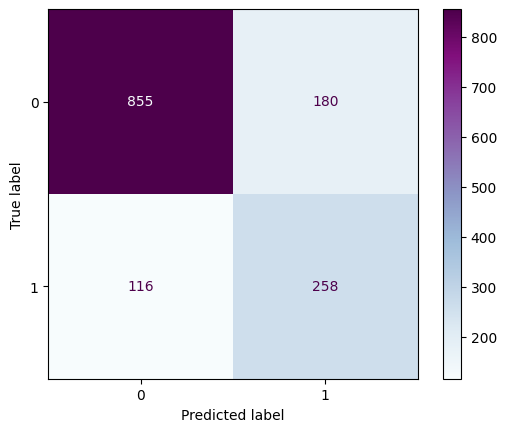

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rf_predictions, labels=pipe_over.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = pipe_over.classes_)
disp = disp.plot(cmap = plt.cm.BuPu)
plt.grid(False);

- Verdadeiros Positivos (True Positives - TP): 258 casos
- Verdadeiros Negativos (True Negatives - TN): 855 casos
- Falsos Positivos (False Positives - FP): 180 casos
- Falsos Negativos (False Negatives - FN): 116 casos

## Visualizando ROC e AUC para o Modelo Random Florest

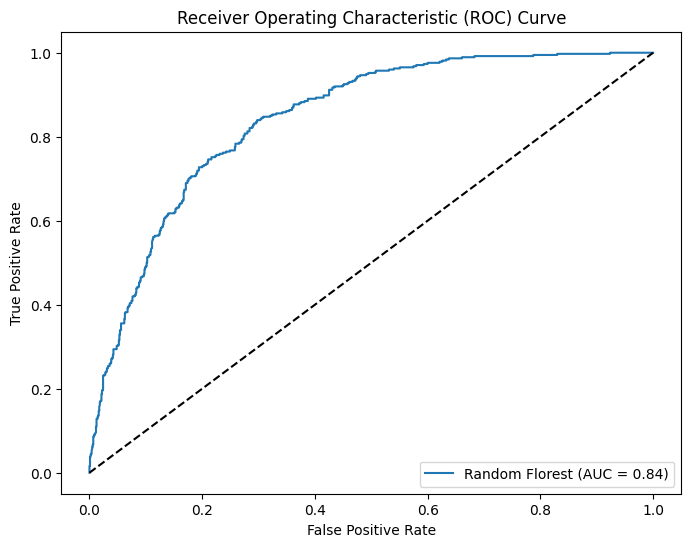

In [34]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

y_pred_prob = pipe_over.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
auc_score = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Florest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Veja que o modelo de Random Florest com uma área sob a curva (AUC) de 0,84 indica que ele possui um poder discriminatório satisfatório na distinção entre as classes no conjunto de test.

## Model Explainer (SHAP): Feature Importance e Waterfall 

### Feature Importance

In [51]:
import shap

explainer = shap.TreeExplainer(pipe_over['model'])
observations = pipe_over['preprocessor'].transform(X_test)
shap_values = explainer.shap_values(observations)

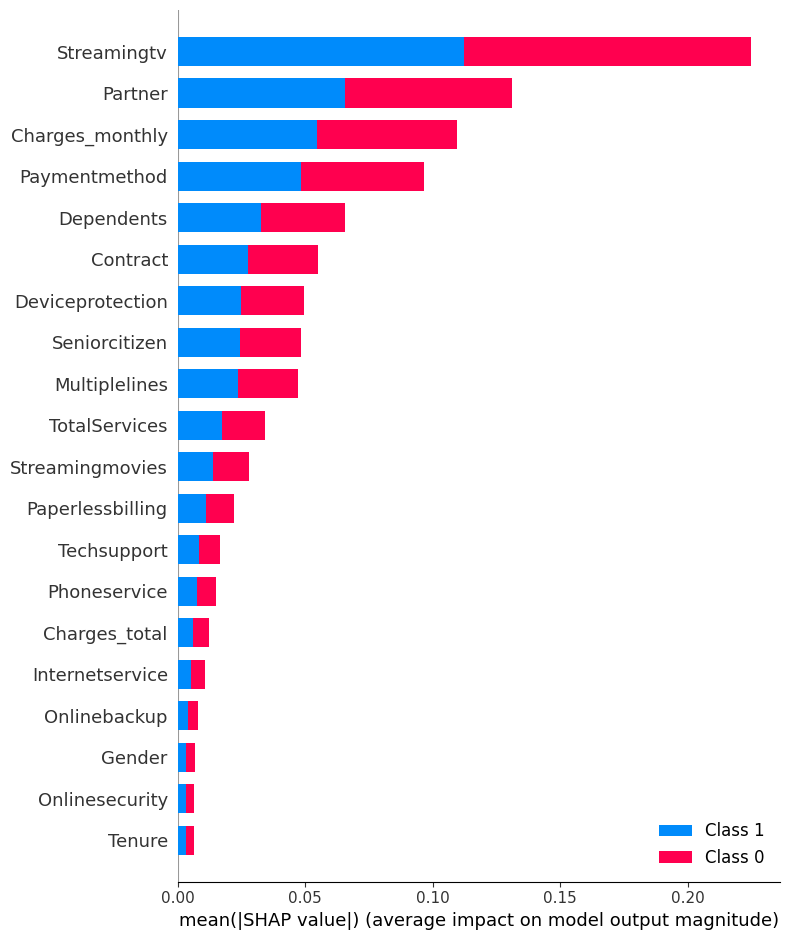

In [52]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Salvando o melhor modelo: CatBoost</h1>
</div>

In [ ]:
import joblib

best_model = DIRETORIO_BASE + 'modelo_catboost.pkl'
joblib.dump(catboost, best_model)

['/content/drive/MyDrive/Github/AluraDataChallenge_2/modelo_catboost.pkl']